# Кластеризация. Домашка

## Совсем простая рекомендательная система

На основе оценок аниме, которые ставят пользователи систем типа [MAL](https://myanimelist.net/), можно строить разные кластеры данных:
- кластеры похожих людей. Похожие значит, что эти люди ставят похожие рейтинги аниме.
- кластеры похожих аниме. Похожие значит что люди оценивают их похоже.
- кластеры похожих жанров. Но похожие не в обычном смысле, а в смысле, что люди которые смотрят жанр А любят смотреть жанр Б.

и т.д.

### Полезная литература

- [Лекция 8. Рекомендательный системы](https://www.youtube.com/watch?v=Te_6TqEhyTI&t=4s).
- [Туториал по рекомендательным системам](http://nbviewer.jupyter.org/urls/gitlab.7bits.it/isiganov/ml-course/raw/master/week05/theory/05-01-clustering.ipynb?inline=false)
- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную



In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

from tqdm import tqdm
# from tqdm import tqdm_notebook as tqdm # Раскоментируйте если прогресс бар будет странно работать

%matplotlib inline

# Зафиксируем случайность, чтобы у нас получались одинаковые результаты.
np.random.seed(seed=42)

## Анализ отзывов аниме

Возьмем датасет с рейтингами аниме: https://www.kaggle.com/CooperUnion/anime-recommendations-database  
Кстати, вы можете посмотреть kernels - это jupyter notebooks, в которых другие люди тоже делали что-то с этим датасетом.

```
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
genre - comma separated list of genres for this anime.
type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's "group".


Rating.csv

user_id - non identifiable randomly generated user id.
anime_id - the anime that this user has rated.
rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
```

In [2]:
colab = False  # True если используте google colab
if colab:
    from google.colab import drive
    drive.mount('/content/drive/')

In [3]:
if colab:
    anime = pd.read_csv('/content/drive/My Drive/Data/anime/anime.csv.zip', index_col='anime_id')
else:
    anime = pd.read_csv('/home/rimsky/Projects/ml-solutions/ml_course/data/anime/anime.csv.zip', index_col='anime_id')
anime.dropna(inplace=True)
print(anime.shape)
anime.head()

(12017, 6)


,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
if colab:
    ratings = pd.read_csv('/content/drive/My Drive/Data/anime/rating.csv.zip')
else:
    ratings = pd.read_csv('/home/rimsky/Projects/ml-solutions/ml_course/data/anime/data_anime_rating.csv.zip')
ratings

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


Датасет очень большой и грязный. Некоторые действия с этим датасетом будут требовать много оперативной памяти(>6 Гб).

## Подготовка данных

Во первых, в датасете есть много -1. Оценки -1 и 0 на MAL нет. 

Здесь -1 означает что человек посмотрел это аниме, но не выставил оценку.

Такие записи из `ratings` стоит выбросить, так как в нашем случае они особо не помогут. 

Но и не помешают серьезно. Если хотите оставьте их, только нужно заменить все -1 на 0, так как дальше нам понадобится посчитать среднее, а -1 или 0, в отличие от `np.nan`, повлияют на среднее. 

### 1. Избавьтесь от -1

In [5]:
ratings.loc[ratings['rating'] < 0, 'rating'] = 0
ratings

,user_id,anime_id,rating
0,1,20,0
1,1,24,0
2,1,79,0
3,1,226,0
4,1,241,0
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


## Критерий Шавене (Chauvenet)

[Теория](https://www.youtube.com/watch?v=Fy9pHH3ykPE&list=PLLyuiBK_HOLPfRVN6r9305FKXq1ravbbX)

$$ erfc(\frac{|P_i - mean(P)|}{S_p})  < \frac{1}{2n}$$

$ S_p - отклонение $

Готовой реализации в библиотеках нет, поэтому придется написать самим(но если найдете можете использовать).

### 2. Напишите функцию, которая принимает на вход массив, считает критерий Шавене и возвращает булеву маску.

Функция `erfc` есть в sklearn. 

In [6]:
from scipy.special import erfc

def chauvenet(array):
    mean = array.mean()           
    stdv = array.std()            
    N = len(array)              
    criterion = 1.0/(2*N)         
    d = abs(array-mean)/stdv      
    prob = erfc(d)      
    mask = prob < criterion        
    return mask

Для начала давайте посмотрим на таблицу рейтингов.

### 3. Сделайте новую таблицу `count_reviews` где индексами будет `user_id` а значением будет количество просмотренных им аниме.


**Hint** Используйте [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) и [count](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.count.html).

In [7]:
count_reviews = ratings
count_reviews = count_reviews.set_index('user_id')
count_reviews = count_reviews.groupby(by='user_id').count()
count_reviews['count_reviews'] = count_reviews['rating']
count_reviews = count_reviews.drop(columns=['anime_id', 'rating'])
count_reviews

,count_reviews
user_id,
1,153
2,3
3,94
4,52
5,467
...,...
73512,13
73513,33
73514,1


### 4. Используйте функцию chauvenet и найдите все выбросы.

**Hint:** Так как chauvenet возвращает маску используйте оператор `[]` (подробнее смотрите в 1 теории по pandas и numpy).

**Hint:** Используйте [values](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.values.html).

In [8]:
outlier_users = count_reviews[chauvenet(count_reviews.values)]
outlier_users 

,count_reviews
user_id,
17,601
54,834
226,742
271,599
294,675
...,...
73234,812
73286,760
73362,613


### 5. Ответьте на вопросы

#### Кого критерий посчитал выбросом?

#### Почему критерий посчитал их выбросом?

#### Нужна ли им вообще рекомендательная система?


**Ответы:**

**Критерий принял за выброс неадекватно большое значение. Такое количество аниме не возможно просмотреть в рамках короткой человеческой жизни:(
Возможно, это был бот, который накручивал оценки фильмам?**

**Быть может, стоит прогнать датасет через критерий еще раз (спойлер: я так и сделал, ситуацию это поменяло не сильно, хотя значения в пару тысяч аниме, по моим меркам тоже очень много)**

**Человек, который видел такое количество аниме сам превращается в рекомендательную систему:)**

In [9]:
bad_user_threshold = outlier_users.min()
bad_user_threshold

count_reviews    594
dtype: int64

Если все было правильно `bad_user_threshold` больше 500. 

Нужно выбросить всех людей у которых число просмотренных аниме больше или равно `bad_user_threshold`.

### 6. Переименнуйте столбец из таблицы `count_reviews` в `count_reviews` (он там единственный). Соедините `count_reviews` и `ratings` по столбцу `user_id`. И оставьте в `ratings` только тех кто посмотрел меньше `bad_user_threshold`  

In [10]:
bad_user_threshold.values[0]

594

In [11]:
ratings = ratings.merge(count_reviews, on='user_id')
ratings = ratings.drop(np.where(ratings['count_reviews'] >= bad_user_threshold.values[0])[0], axis=0)
ratings


,user_id,anime_id,rating,count_reviews
0,1,20,0,153
1,1,24,0,153
2,1,79,0,153
3,1,226,0,153
4,1,241,0,153
...,...,...,...,...
7813732,73515,16512,7,196
7813733,73515,17187,9,196
7813734,73515,22145,10,196
7813735,73516,790,9,2


In [12]:
ratings = ratings.drop(ratings[chauvenet(ratings['count_reviews'])].index)
ratings

,user_id,anime_id,rating,count_reviews
0,1,20,0,153
1,1,24,0,153
2,1,79,0,153
3,1,226,0,153
4,1,241,0,153
...,...,...,...,...
7813732,73515,16512,7,196
7813733,73515,17187,9,196
7813734,73515,22145,10,196
7813735,73516,790,9,2


Осталось все равно слишком много пользователей.

### 7. Удалите из таблицы всех юзеров, у которых количество просмотров меньше медианного значения. То есть мы удалим половину юзеров.

Так как они посмотрели слишком мало, чтобы мы на них могли основывать свои советы.

In [13]:
median = int(ratings['count_reviews'].median())
print(median)
ratings = ratings.drop(ratings[ratings['count_reviews'] < median].index)
ratings

186


,user_id,anime_id,rating,count_reviews
302,5,6,8,467
303,5,15,6,467
304,5,17,6,467
305,5,18,6,467
306,5,20,6,467
...,...,...,...,...
7813730,73515,13659,8,196
7813731,73515,14345,7,196
7813732,73515,16512,7,196
7813733,73515,17187,9,196


In [14]:
# Удалим столбец с просмотрами чтобы не мешал.

ratings = ratings.drop(columns=['count_reviews'])

Теперь рассмотрим таблицу `anime`. 


Так же применим критерий шавене.

Искать выбросы стоит по столбцу `rating` или по `members` или по обоим сразу.

### 8. Используйте функцию chauvenet и найдите все выбросы среди аниме. И удалите их.

**Hint** Используйте [drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) и [index](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.index.html)

In [15]:
outlier_anime = anime[chauvenet(anime['members'])]
outlier_anime

,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
4181,Clannad: After Story,"Drama, Fantasy, Romance, Slice of Life, Supern...",TV,24,9.06,456749
...,...,...,...,...,...,...
9041,IS: Infinite Stratos,"Action, Comedy, Harem, Mecha, Sci-Fi",TV,12,7.12,254543
7593,Kiss x Sis (TV),"Comedy, Ecchi, Harem, Romance, School, Seinen",TV,12,7.09,215361
11285,Black★Rock Shooter (TV),"Action, Drama, School, Slice of Life",TV,8,7.07,198991


In [16]:
anime_members_outlier = anime.drop(anime[chauvenet(anime['members'])].index)
anime_members_outlier

,name,genre,type,episodes,rating,members
anime_id,,,,,,
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
...,...,...,...,...,...,...
9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
5543,Under World,Hentai,OVA,1,4.28,183
5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219


In [17]:
outlier_anime = anime[chauvenet(anime['rating'])]
outlier_anime

,name,genre,type,episodes,rating,members
anime_id,,,,,,
2792,Panzer Dragoon,"Adventure, Fantasy",OVA,1,3.47,1047
11883,Nendo no Tatakai 2,"Comedy, Fantasy",ONA,1,3.46,1042
29617,Good-by Elvis and USA,"Dementia, Music",Movie,1,3.41,367
11897,Nendo no Tatakai,"Comedy, Fantasy",ONA,1,3.36,1174
32894,Love Bites,Horror,ONA,1,3.33,537
...,...,...,...,...,...,...
20007,Hi Gekiga Ukiyoe Senya Ichiya,"Action, Hentai",Movie,1,1.92,129
17825,Ikenai Boy: Ikasu Maruhi Hand Power,"Comedy, Hentai",OVA,1,3.11,112
23677,Manga Edo Erobanashi,"Comedy, Hentai, Historical",OVA,5,2.86,111


In [18]:
outlier_anime = anime[chauvenet(anime['members']) & chauvenet(anime['rating'])]
outlier_anime

,name,genre,type,episodes,rating,members
anime_id,,,,,,


In [19]:
anime = anime.drop(anime[chauvenet(anime['rating'])].index)
anime

,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...
9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
5543,Under World,Hentai,OVA,1,4.28,183
5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219


In [20]:
print(anime['members'].mean())
print(anime['members'].median())
print(anime['rating'].median())
print(anime['rating'].mean())

18484.755052410903
1585.0
6.58
6.502430188679253


### 9. Ответье на вопросы

#### Что критерий посчитал выбросом? 

#### Почему критерий посчитал их выбросом? 

#### Можем ли мы как то использовать эти аниме в нашей рекомендательное системе? 

**Ответы:**

   **Если искать выбросы по 'members', то за выбросы алгоритм принимает наиболее популярные по просмотрам сериалы.
Если же по 'rating', то выбросами становятся аниме с наименьшим рейтингом, а значит, как правило, наименее популярные по просмотрам**

   **Критерий счел наиболее популярные аниме выбросами, возможно потому, что они очень сильно отличаются от среднего, так же дело обстоит и с выбросами по рейтингу**

   **На мой взгляд, в рекомендательной системе более разумно искать выбросы по рейтингу, т.к. таким образом мы отсеиваем наименее популярные аниме, которые с высокой долей вероятности не зайдут нашей целевой аудитории**

## Кластеризация по жанрам

Данные о жанре хранятся как строка, разделенная запятой `,` . Но нам нужны сами жанры. Придется поколдовать и разделить эту строку на элементы. 

In [21]:
from itertools import chain
'''
Нам нужна функция flatmap.
Flatmap получает на вход список, на каждом элементе вызывает функцию f, которая возвращает другой список.
В результате получается список списков. В конфе происходит flatten - уплощение списка скписков в один список.
'''
def flatmap(f, items):
    return chain.from_iterable(map(f, items))

# пример использования
list(flatmap(lambda x: [0, x , x*x], [1,2,3,4,5]))
# Первый шаг: [[0, 1, 1], [0, 2, 4], [0, 3, 9], [0, 4, 16], [0, 5, 25]]

[0, 1, 1, 0, 2, 4, 0, 3, 9, 0, 4, 16, 0, 5, 25]

In [22]:
# создаем функцию, которая просто разбивает строку по символу ", " на подстроки
def genre_splitter(genre_names):
    return genre_names.split(", ")

m_uniq = anime['genre'].unique() # смотрим сколько всего уникальных комбинация genres есть в датасете
print("m_uniq[0:10] = {}\nlen= {}\n".format(m_uniq[0:10], len(m_uniq))) # как видим комбинаций очень много, так как там все композиции

genres = set(flatmap(genre_splitter, m_uniq)) # разбиваем все genres на составные части и генерируем один массив из всех жанров. Строим по массиву множество уникальных жанров

genres = list(genres) # множество превращаем в список
print("Genres={}\nlen={}".format(genres, len(genres)))

m_uniq[0:10] = ['Drama, Romance, School, Supernatural'
 'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen'
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen'
 'Sci-Fi, Thriller' 'Comedy, Drama, School, Shounen, Sports'
 'Action, Adventure, Shounen, Super Power'
 'Drama, Military, Sci-Fi, Space'
 'Drama, Fantasy, Romance, Slice of Life, Supernatural'
 'Drama, School, Shounen'
 'Action, Drama, Mecha, Military, Sci-Fi, Super Power']
len= 3223

Genres=['Hentai', 'Action', 'Supernatural', 'Adventure', 'Slice of Life', 'Mystery', 'Yuri', 'Demons', 'Josei', 'Mecha', 'Sports', 'Martial Arts', 'Shoujo', 'Space', 'Horror', 'Psychological', 'Drama', 'Dementia', 'Magic', 'School', 'Shounen', 'Seinen', 'Game', 'Shoujo Ai', 'Sci-Fi', 'Comedy', 'Fantasy', 'Historical', 'Parody', 'Cars', 'Romance', 'Military', 'Yaoi', 'Thriller', 'Kids', 'Harem', 'Super Power', 'Music', 'Vampire', 'Samurai', 'Police', 'Shounen Ai', 'Ecchi']
len=43


### 10. Создадим новую таблицу, где в колонках будет жанр, в строках аниме, а в ячейках 1 если у фильма есть этот жанр и 0 в противном случае.

Такой формат таблиц называтеся one-hot-encoding. Только в нашем случае в каждой строке будет не одна единица, а несколько, так как у аниме как правило несолько жанров.

Уточнение: жанры должны быть индексами столбцов (columns), а id аниме - индексами строк (index)

In [23]:
df_genres = pd.DataFrame(index = anime.index, columns=genres)

for col in df_genres.columns:
        mask = anime['genre'].str.contains(col)
        df_genres[col] = mask
        df_genres[col] = df_genres[col].astype(int)
df_genres

,Hentai,Action,Supernatural,Adventure,Slice of Life,Mystery,Yuri,Demons,Josei,Mecha,...,Thriller,Kids,Harem,Super Power,Music,Vampire,Samurai,Police,Shounen Ai,Ecchi
anime_id,,,,,,,,,,,,,,,,,,,,,
32281,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5114,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28977,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9253,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9969,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9316,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5543,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5621,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Итак, у нас есть следующие таблицы:
- Жанры аниме - в строчках аниме, в столбцах жанр аниме, а в ячейках 0 или 1.
- Рейтинги - в строчках пользователи, в столбцах id аниме и рейтинг

Нужно получить другую таблицу, в которой в строках будут пользователи, а в столбцах жанры аниме. А в ячейках средняя оценка жанра этим пользователем.

Средняя оценка жанра вычисляется следующим образом: берём все отзывы пользователя. Группируем все его отзывы по жанрам и считаем средний рейтинг, который он ставит аниме с данным жанром.

Выполним следущие шаги.

### 11. Соединим две таблицы:<br>
1. жанры по каждому аниме<br>
2. оценки аниме от людей. Кстати, один человек мог посмотреть 1 аниме или 100, но не все!<br>

Получим таблицу, где строк будет N*M штук, где N - количество юзеров и M - количество аниме

In [24]:
df = ratings.join(df_genres, on='anime_id')
df

,user_id,anime_id,rating,Hentai,Action,Supernatural,Adventure,Slice of Life,Mystery,Yuri,...,Thriller,Kids,Harem,Super Power,Music,Vampire,Samurai,Police,Shounen Ai,Ecchi
302,5,6,8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
303,5,15,6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304,5,17,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
305,5,18,6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306,5,20,6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7813730,73515,13659,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7813731,73515,14345,7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7813732,73515,16512,7,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7813733,73515,17187,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


С такой таблицей `(N*M) * G` вы всё еще не можем работать.  
### 12. Сгруппируем строки по пользователям (колонка `userId`).  В группах посчитаем среднюю оценку на жанр. А если пользователь не смотрел фильм, то поставим ему `-1` в соответсвующую ячейку.
Чтобы посчитать среднее(mean) без учета непросмотренных аниме замените все `0` на `np.NaN`

In [25]:
for col in df.columns:
    if col != 'anime_id' and col != 'rating' and col != 'user_id':
        df[col] = df[col] * df['rating']
df

,user_id,anime_id,rating,Hentai,Action,Supernatural,Adventure,Slice of Life,Mystery,Yuri,...,Thriller,Kids,Harem,Super Power,Music,Vampire,Samurai,Police,Shounen Ai,Ecchi
302,5,6,8,0.0,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
303,5,15,6,0.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304,5,17,6,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
305,5,18,6,0.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306,5,20,6,0.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7813730,73515,13659,8,0.0,0.0,0.0,0.0,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7813731,73515,14345,7,0.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7813732,73515,16512,7,0.0,7.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7813733,73515,17187,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0


In [26]:
df.replace(0.0, np.nan, inplace=True)

In [28]:
df = df.groupby(by='user_id').mean()
df

,anime_id,rating,Hentai,Action,Supernatural,Adventure,Slice of Life,Mystery,Yuri,Demons,...,Thriller,Kids,Harem,Super Power,Music,Vampire,Samurai,Police,Shounen Ai,Ecchi
user_id,,,,,,,,,,,,,,,,,,,,,
5,11023.301927,4.280514,NaN,4.701299,4.346939,5.186813,4.506849,4.040000,NaN,4.157895,...,7.285714,5.555556,2.217949,4.170732,4.727273,4.428571,7.166667,2.500000,NaN,2.510000
7,15824.320700,7.387755,NaN,7.484127,7.631579,7.700000,7.137255,7.923077,NaN,7.250000,...,8.363636,8.500000,7.111111,7.939394,6.571429,7.444444,6.000000,7.500000,NaN,6.909091
38,13640.897233,6.703557,NaN,6.925714,6.969072,7.775000,6.437500,7.648649,NaN,5.937500,...,8.052632,NaN,4.212121,7.175000,6.666667,6.214286,6.666667,6.000000,3.000000,4.324324
43,14817.133803,7.644366,NaN,7.823834,7.673077,7.828571,7.444444,7.846154,NaN,7.850000,...,7.833333,NaN,7.717949,7.811321,NaN,7.466667,8.250000,7.571429,6.000000,7.655172
46,14830.811377,8.565868,NaN,8.454545,8.451613,8.750000,8.924528,8.593750,NaN,8.250000,...,9.000000,6.500000,7.185185,8.333333,8.666667,7.384615,8.416667,9.200000,6.444444,7.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73491,2740.895652,0.440580,NaN,9.000000,9.200000,9.000000,9.500000,9.000000,NaN,8.000000,...,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,9.000000,10.000000,10.000000
73502,7171.731373,8.496078,NaN,8.658228,8.894309,8.813953,8.885965,9.101695,NaN,8.153846,...,9.555556,6.000000,8.000000,9.129032,8.833333,8.083333,6.333333,9.000000,NaN,7.744186
73503,11336.808943,6.418699,NaN,6.389610,6.489796,6.157895,7.277778,7.204082,NaN,5.954545,...,7.476190,NaN,4.700000,6.428571,8.500000,6.125000,6.333333,8.000000,NaN,5.230769


Так как некоторые пользователи не смотрели ничего из некоторых жанров, в данных осталось много `np.NaN`
### 13. Заполните все NaN на -1

**Hint** [fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)

In [29]:
df = df.fillna(-1)
df.head()

,anime_id,rating,Hentai,Action,Supernatural,Adventure,Slice of Life,Mystery,Yuri,Demons,...,Thriller,Kids,Harem,Super Power,Music,Vampire,Samurai,Police,Shounen Ai,Ecchi
user_id,,,,,,,,,,,,,,,,,,,,,
5,11023.301927,4.280514,-1.0,4.701299,4.346939,5.186813,4.506849,4.040000,-1.0,4.157895,...,7.285714,5.555556,2.217949,4.170732,4.727273,4.428571,7.166667,2.500000,-1.000000,2.510000
7,15824.320700,7.387755,-1.0,7.484127,7.631579,7.700000,7.137255,7.923077,-1.0,7.250000,...,8.363636,8.500000,7.111111,7.939394,6.571429,7.444444,6.000000,7.500000,-1.000000,6.909091
38,13640.897233,6.703557,-1.0,6.925714,6.969072,7.775000,6.437500,7.648649,-1.0,5.937500,...,8.052632,-1.000000,4.212121,7.175000,6.666667,6.214286,6.666667,6.000000,3.000000,4.324324
43,14817.133803,7.644366,-1.0,7.823834,7.673077,7.828571,7.444444,7.846154,-1.0,7.850000,...,7.833333,-1.000000,7.717949,7.811321,-1.000000,7.466667,8.250000,7.571429,6.000000,7.655172
46,14830.811377,8.565868,-1.0,8.454545,8.451613,8.750000,8.924528,8.593750,-1.0,8.250000,...,9.000000,6.500000,7.185185,8.333333,8.666667,7.384615,8.416667,9.200000,6.444444,7.142857


Прежде чем начать обучать kMeans...

### 14. Отмасштабируйте признаки.

Как мы знаем по лекции, метрическим алгоритмам, одним из которых и является kMeans, лучше подавать на вход данные одного масштаба.  Этим и занимается метод MinMaxScaler из sklearn.

[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

Алгоритм его работы:
```
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```

In [30]:
df = df.drop(columns=['anime_id', 'rating'])
df

,Hentai,Action,Supernatural,Adventure,Slice of Life,Mystery,Yuri,Demons,Josei,Mecha,...,Thriller,Kids,Harem,Super Power,Music,Vampire,Samurai,Police,Shounen Ai,Ecchi
user_id,,,,,,,,,,,,,,,,,,,,,
5,-1.0,4.701299,4.346939,5.186813,4.506849,4.040000,-1.0,4.157895,7.000000,2.000000,...,7.285714,5.555556,2.217949,4.170732,4.727273,4.428571,7.166667,2.500000,-1.000000,2.510000
7,-1.0,7.484127,7.631579,7.700000,7.137255,7.923077,-1.0,7.250000,-1.000000,8.043478,...,8.363636,8.500000,7.111111,7.939394,6.571429,7.444444,6.000000,7.500000,-1.000000,6.909091
38,-1.0,6.925714,6.969072,7.775000,6.437500,7.648649,-1.0,5.937500,4.000000,7.058824,...,8.052632,-1.000000,4.212121,7.175000,6.666667,6.214286,6.666667,6.000000,3.000000,4.324324
43,-1.0,7.823834,7.673077,7.828571,7.444444,7.846154,-1.0,7.850000,-1.000000,7.250000,...,7.833333,-1.000000,7.717949,7.811321,-1.000000,7.466667,8.250000,7.571429,6.000000,7.655172
46,-1.0,8.454545,8.451613,8.750000,8.924528,8.593750,-1.0,8.250000,8.352941,9.142857,...,9.000000,6.500000,7.185185,8.333333,8.666667,7.384615,8.416667,9.200000,6.444444,7.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73491,-1.0,9.000000,9.200000,9.000000,9.500000,9.000000,-1.0,8.000000,-1.000000,10.000000,...,-1.000000,-1.000000,10.000000,-1.000000,-1.000000,-1.000000,-1.000000,9.000000,10.000000,10.000000
73502,-1.0,8.658228,8.894309,8.813953,8.885965,9.101695,-1.0,8.153846,9.181818,8.263158,...,9.555556,6.000000,8.000000,9.129032,8.833333,8.083333,6.333333,9.000000,-1.000000,7.744186
73503,-1.0,6.389610,6.489796,6.157895,7.277778,7.204082,-1.0,5.954545,6.750000,6.809524,...,7.476190,-1.000000,4.700000,6.428571,8.500000,6.125000,6.333333,8.000000,-1.000000,5.230769


In [39]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = scaler.fit_transform(df)
data

array([[0.        , 0.51829988, 0.48608534, ..., 0.31818182, 0.        ,
        0.31909091],
       [0.        , 0.77128427, 0.784689  , ..., 0.77272727, 0.        ,
        0.71900826],
       [0.        , 0.72051948, 0.72446111, ..., 0.63636364, 0.36363636,
        0.48402948],
       ...,
       [0.        , 0.67178276, 0.68089054, ..., 0.81818182, 0.        ,
        0.56643357],
       [0.        , 0.8019802 , 0.7994228 , ..., 0.86363636, 0.        ,
        0.69556025],
       [0.        , 0.88026608, 0.89015152, ..., 0.93939394, 0.        ,
        0.81818182]])

### 15.Натренируйте kMeans с 10 кластерами на полученных данных

In [40]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(data)


### 16. Нарисуйте на графике центры кластеров нашего датасета оценок фильмов.

В нем будет 10 строчек - 10 кластеров. И 43 столбцов - 43 жанров фильмов.

Из графика мы поймем какие жанры обычно смотрят вместе. По сути мы получили кластеры предпочтений людей.

**Hint** [Heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

In [128]:
clstrs = np.around(kmeans.cluster_centers_, decimals=2)
df_data = pd.DataFrame(clstrs, columns=genres)
df_data

,Hentai,Action,Supernatural,Adventure,Slice of Life,Mystery,Yuri,Demons,Josei,Mecha,...,Thriller,Kids,Harem,Super Power,Music,Vampire,Samurai,Police,Shounen Ai,Ecchi
0,0.06,0.86,0.84,0.79,0.71,0.74,0.02,0.39,0.13,0.54,...,0.53,0.08,0.46,0.70,0.29,0.29,0.17,0.23,0.06,0.57
1,0.26,0.80,0.81,0.80,0.80,0.82,0.13,0.77,0.00,0.81,...,0.84,0.46,0.74,0.80,0.73,0.78,0.75,0.79,0.08,0.75
2,0.00,0.04,0.02,0.01,0.03,0.02,0.00,0.00,0.00,0.01,...,0.02,0.00,0.00,0.01,0.01,0.00,0.00,0.01,0.00,0.01
3,0.10,0.82,0.83,0.83,0.83,0.83,0.06,0.80,0.84,0.80,...,0.86,0.39,0.76,0.82,0.78,0.78,0.69,0.78,0.19,0.76
4,0.18,0.79,0.80,0.80,0.80,0.82,0.09,0.77,0.83,0.80,...,0.84,0.42,0.72,0.79,0.78,0.76,0.73,0.81,0.13,0.72
5,0.24,0.78,0.78,0.78,0.79,0.80,0.10,0.75,0.82,0.78,...,0.83,0.48,0.70,0.77,0.79,0.76,0.76,0.80,0.14,0.71
6,0.53,0.81,0.82,0.81,0.82,0.83,0.21,0.81,0.77,0.79,...,0.84,0.58,0.75,0.81,0.79,0.78,0.70,0.80,0.75,0.74
7,0.18,0.83,0.83,0.84,0.82,0.84,0.10,0.81,0.00,0.81,...,0.85,0.37,0.78,0.83,0.66,0.79,0.81,0.75,0.06,0.78
8,0.12,0.80,0.81,0.81,0.80,0.82,0.06,0.75,0.24,0.77,...,0.82,0.32,0.74,0.80,0.72,0.75,0.02,0.66,0.09,0.74
9,0.03,0.70,0.56,0.46,0.33,0.24,0.01,0.11,0.02,0.13,...,0.15,0.02,0.17,0.31,0.07,0.09,0.07,0.05,0.02,0.23


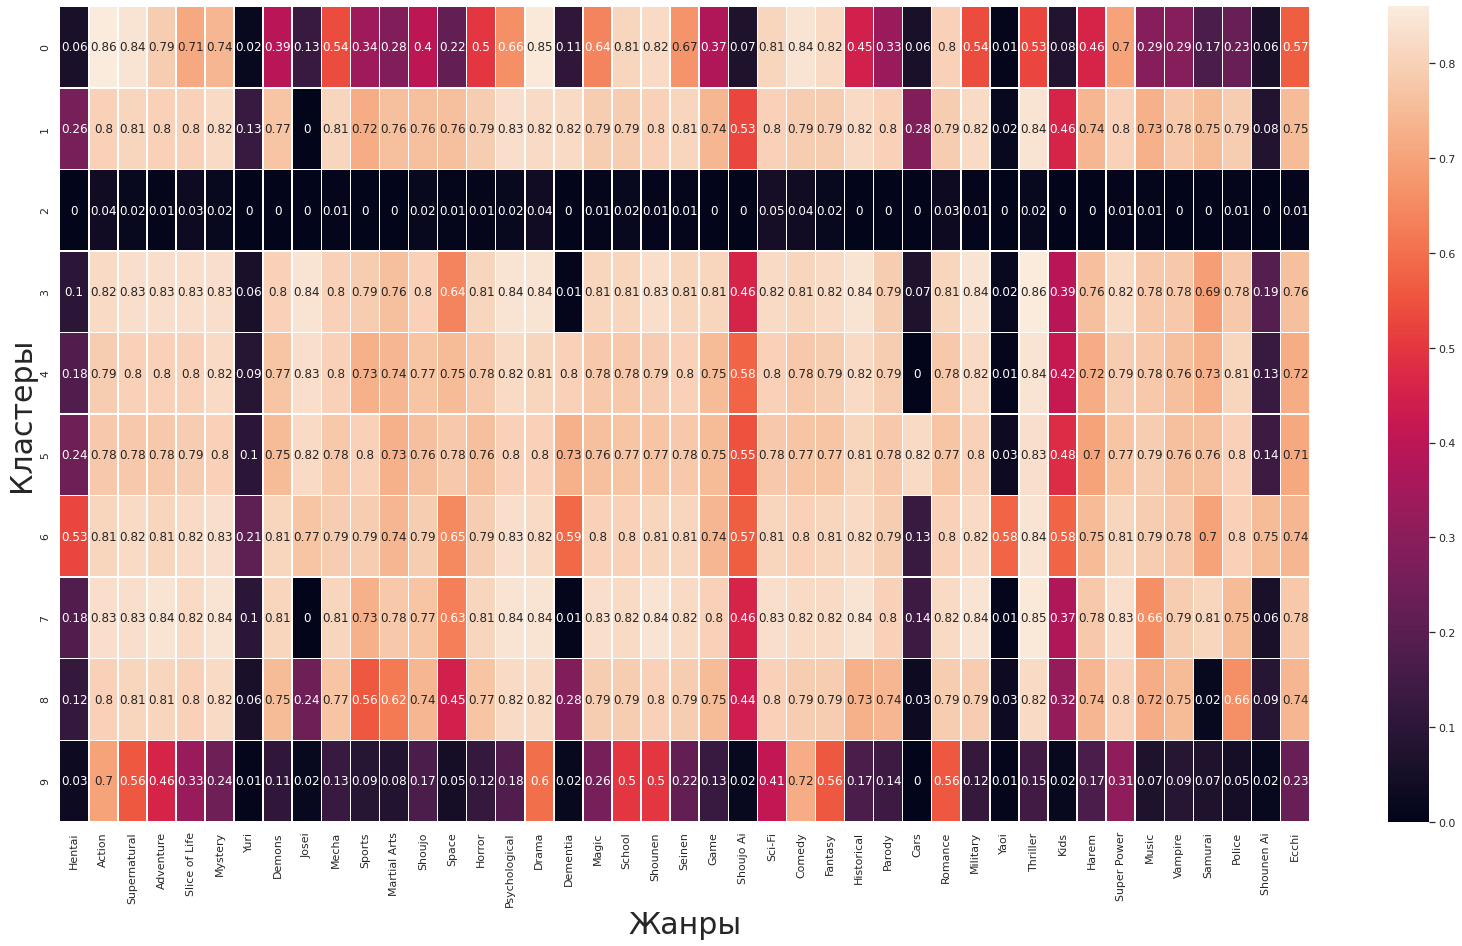

In [129]:
plt.figure(figsize=(28, 15))
ax = sns.heatmap(df_data, linewidths = .5, annot=True)
plt.xlabel('Жанры',fontsize=30)
plt.ylabel('Кластеры', fontsize=30)
plt.show()

# Как выбрать нужное число кластеров

Такие методы как KMeans, Spectral clustering, Ward hierarchical clustering, Agglomerative clustering требуют количество кластеров как параметр. Это так называемый гипер-параметр, и его должен подбирать человек. Но на что человеку опираться при выборе? На некоторый функционал "качества"!

Вспомним идею кластеризации:
- минимизация внутрикластерного расстояния
- максимизация межкластерного расстояния

Другими словами - кучки кучнее и дальше друг от друга.

Логично, что мы хотим, чтобы точки распологались кучно возле центров своих кластеров. Но вот незадача: минимум такого функционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента). Для решения этого вопроса (выбора числа кластеров) часто пользуются такой эвристикой: выбирают то число кластеров, начиная с которого описанный функционал $ J(C) $ падает "уже не так быстро". Или более формально: $$ D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k $$

Где, в случае kMeans $$ J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$ - сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся

#### Эта ячейка может выполнятся долго!

100%|██████████| 29/29 [00:48<00:00,  1.68s/it]


Text(0, 0.5, '$J(C_k)$')

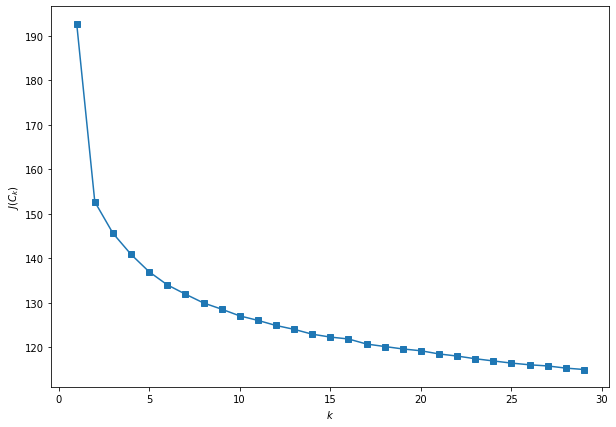

In [34]:
inertia = []
N = 30
for k in tqdm(range(1, N)):
    kmeans = KMeans(n_clusters=k).fit(scaler.fit_transform(df))
    inertia.append(np.sqrt(kmeans.inertia_))
plt.figure(figsize=(10,7))
plt.plot(range(1, N), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')

## Коэффициент силуэта

Данный коэффициент не предполагает знания истинных меток объектов, и позволяет оценить качество кластеризации, используя только саму (неразмеченную) выборку и результат кластеризации. 

Сначала силуэт определяется отдельно для каждого объекта. Обозначим через $a$ - среднее расстояние от данного объекта до объектов из того же кластера, через $b$ - среднее расстояние от данного объекта до объектов из ближайшего кластера (отличного от того, в котором лежит сам объект). Тогда силуэтом данного объекта называется величина: $$s = \frac{b - a}{\max(a, b)}.$$ Силуэтом выборки называется средняя величина силуэта объектов данной выборки. Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Данная величина лежит в диапазоне $[-1, 1]$. Значения, близкие к -1, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным" четко выделенным кластерам. Таким образом, чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.

С помощью силуэта можно выбирать оптимальное число кластеров $k$ (если оно заранее неизвестно) - выбирается число кластеров, максимизирующее значение силуэта. В отличие от предыдущих метрик, силуэт зависит от формы кластеров, и достигает больших значений на более выпуклых кластерах, получаемых с помощью алгоритмов, основанных на восстановлении плотности распределения.

#### Эта ячейка может выполняться долго!

In [35]:
from sklearn.metrics import silhouette_score, silhouette_samples

def draw_sil_score(X, range_n_clusters=[2, 3, 4, 5, 6, 10, 12, 13, 20]):
    scores = []
    for n_clusters in tqdm(range_n_clusters):
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        scores.append(silhouette_avg)
    plt.plot(range_n_clusters, scores)
    return range_n_clusters[np.argmax(scores)]

100%|██████████| 28/28 [01:27<00:00,  3.14s/it]


2

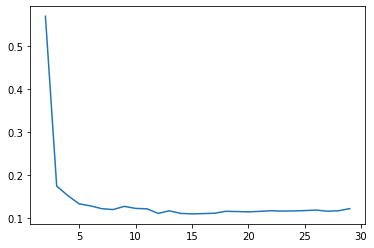

In [36]:
draw_sil_score(scaler.fit_transform(df), range(2, 30))

### 17. Выберите количество кластеров `k` по методам выше. Натренируйте kMeans и снова нарисуйте heatmap.

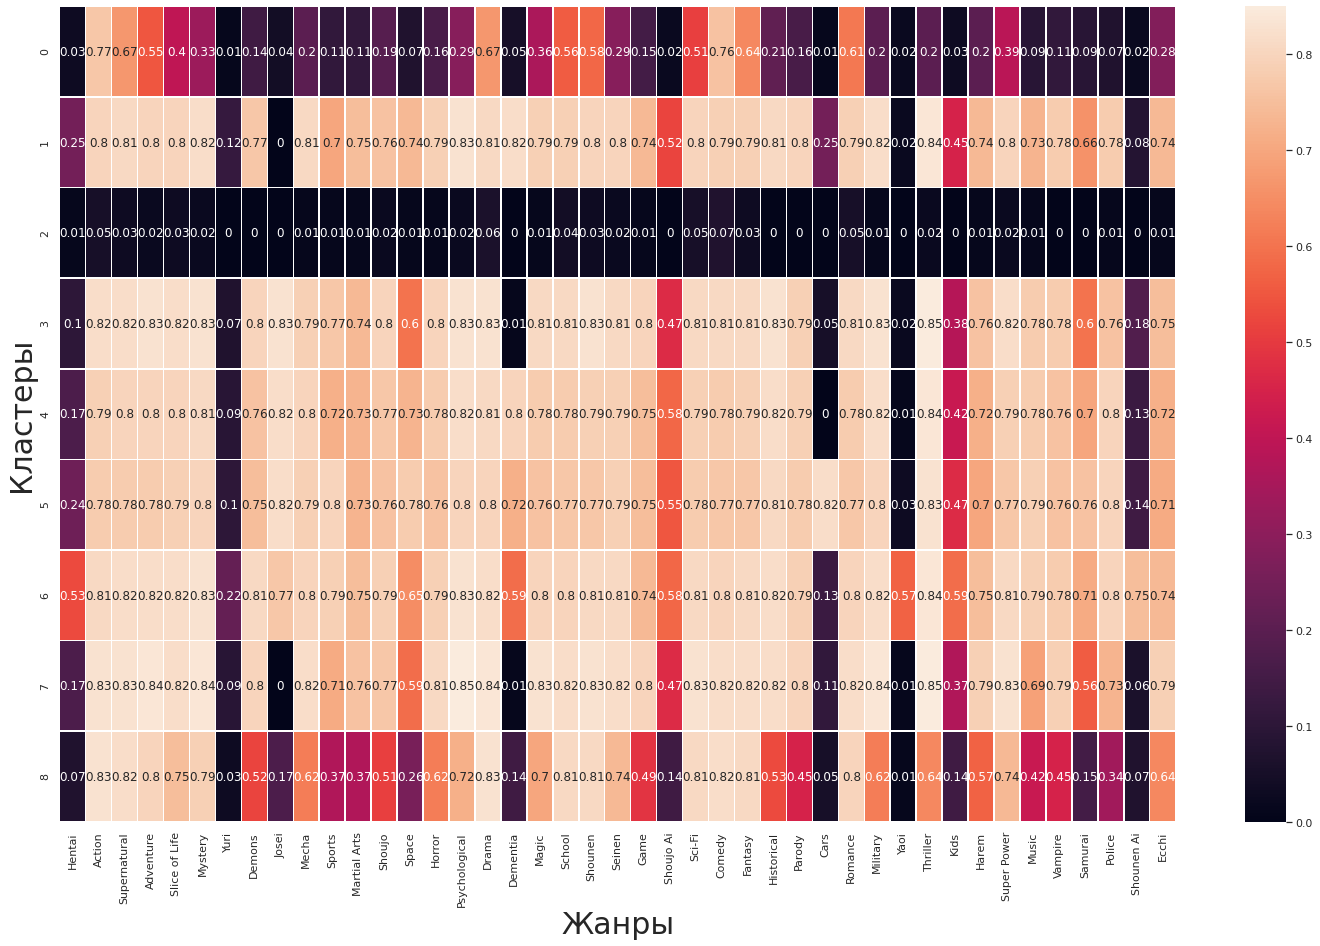

In [138]:
kmeans = KMeans(n_clusters = 9, random_state = 0).fit(data)

df_htm = pd.DataFrame(np.around(kmeans.cluster_centers_, decimals=2), columns=genres)

plt.figure(figsize=(25, 15))
sns.heatmap(df_htm, annot=True, linewidths=.5)
plt.xlabel('Жанры',fontsize=30)
plt.ylabel('Кластеры', fontsize=30)
plt.show()

### 18. Порекомендуйте что-нибудь абстрактному пользователю. 
Это можно сделать разными способами. Как это сделать подумайте сами. 

Если затрудняетесь реализовать это в коде, распишите словами как вы бы это сделали.

Возможные варианты решения:
 * в каждом кластере отсортировать жанры по тому, насколько жанр важен. 
 * взять каждый кластер -> получить все аниме, которые смотрят в этом кластере -> отсортировать по рейтину.



**Можно попробовать следующий вариант: отсортировать жанры по кластерам в порядке важности жанра и затем в ТОП-5
или ТОП-10 жанрах отсортировать аниме по рейтингу и потом выкатывать пользователям данного кластера фильмы
с одновременно топовым (для данного кластера) жанром и рейтингом
P.S. обязательно попробую реализовать это в коде, но чуть позже, т.к. горят дедлайны:)**


### Extra. Попробуйте как-нибудь улучшить эту рекомендашку. Приведите код или рассуждения на эту тему.

Если писать код, то можно:
 * каждому жанру присвоить свой вес, так как одних жанров сильно много и у них разная смысловая нагрузка. Комедии и экшн встречаются очень часто и врядли кто-то только из-за этих жанров будет смотреть аниме.
 * предсказывать не по жанрам, а по аниме. Там получится очень большая размерность, так как нужно сделать one-hot-encoding по аниме, но может это даст лучше результат(спойлер: нет). (И для этого надо сделать 4 join'а, что, возможно, убьет ваш компьютер или/и мозг)

**В теории, можно поэкспериментировать с другими алгоритмами, например, попробовать SVD-разложение, как демонстрировалось в лекции по кластеризации, он достаточно прост и дает интересные результаты**